In [21]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.init as init
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms,datasets
from torch.utils.tensorboard import SummaryWriter

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
class MNISTDataset(Dataset):
    def __init__(self, csv_file_path, transform=None):
        self.data = pd.read_csv(csv_file_path)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data.iloc[idx, 1:].values.astype('float32').reshape((28, 28, 1))
        image = (image / 127.5) - 1.0
        label = int(self.data.iloc[idx, 0])
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [4]:
csv_file_path = '/project/jacobcha/nk643/gans/data/fashion-mnist_train.csv'
transform = transforms.ToTensor()  # Convert images to PyTorch tensors

mnist_dataset = MNISTDataset(csv_file_path, transform=transform)

In [5]:
batch_size = 64
data_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)


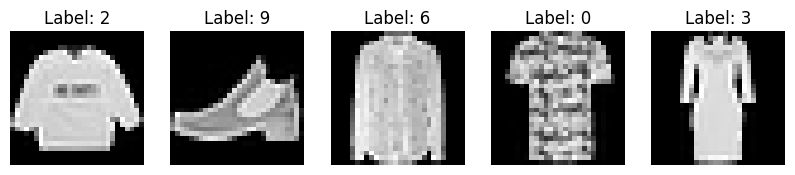

In [7]:
import matplotlib.pyplot as plt

def show_example_data(dataset, num_samples=5):
    plt.figure(figsize=(10, 2))
    
    for i in range(num_samples):
        image, label = dataset[i]
        image = image.numpy().squeeze()  # Convert to numpy array and remove channel dimension for plotting

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')

    plt.show()

# Assuming mnist_dataset is your MNISTDataset instance
show_example_data(mnist_dataset)


In [8]:
batch_size = 128
data_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

In [9]:
# Latent dimension of the random noise
LATENT_DIM = 100

# Number of channels, 1 for grayscale and 3 for color images
CHANNELS = 1  # Change to 3 if working with color images

# Size of the image
IMG_SIZE = 28

# Learning rate
LEARNING_RATE = 0.0002

# Beta1 hyperparam for Adam optimizers
BETA1 = 0.5

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            # FC => BN => ReLU layer
            nn.Linear(LATENT_DIM, 7 * 7 * 256),
            nn.BatchNorm1d(7 * 7 * 256),
            nn.ReLU(True),
            
            # Reshape to (256, 7, 7)
            nn.Unflatten(1, (256, 7, 7)),

            # Upsample to (128, 14, 14)
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # Upsample to (64, 28, 28)
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # Final layer (output)
            nn.Conv2d(64, CHANNELS, kernel_size=5, padding=2),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [11]:
class Discriminator(nn.Module):
    def __init__(self, width, height, depth, alpha=0.2):
        super(Discriminator, self).__init__()

        # Define input shape
        input_shape = (depth, height, width)

        # First set of Conv2D => BatchNorm => LeakyReLU layers
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape[0], out_channels=64, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(alpha)
        )

        # Second set of Conv2D => BatchNorm => LeakyReLU layers
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(alpha)
        )

        # Flatten and apply dropout
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.3)

        # Sigmoid in the last layer outputs a single value for binary classification
        self.final_layer = nn.Sequential(
            nn.Linear(128 * (width // 4) * (height // 4), 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.final_layer(x)
        return x


In [12]:
# Create an instance of the Generator and Discriminator
generator = Generator()
width, height, depth = 28, 28, 1  
discriminator = Discriminator(width, height, depth)

In [13]:
class DCGAN(nn.Module):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def forward(self, real_images):
        batch_size = real_images.size(0)
        noise = torch.randn(batch_size, self.latent_dim).to(real_images.device)

        # Step 1: Train the discriminator
        self.d_optimizer.zero_grad()

        # Real images
        pred_real = self.discriminator(real_images)
        d_loss_real = self.loss_fn(pred_real, torch.ones_like(pred_real))

        # Fake images
        fake_images = self.generator(noise)
        pred_fake = self.discriminator(fake_images.detach())
        d_loss_fake = self.loss_fn(pred_fake, torch.zeros_like(pred_fake))

        d_loss = (d_loss_real + d_loss_fake) / 2.0
        d_loss.backward()
        self.d_optimizer.step()

        # Step 2: Train the generator
        self.g_optimizer.zero_grad()

        pred_fake = self.discriminator(fake_images)
        g_loss = self.loss_fn(pred_fake, torch.ones_like(pred_fake))

        g_loss.backward()
        self.g_optimizer.step()

        return {"d_loss": d_loss.item(), "g_loss": g_loss.item()}

    def compute_metrics(self, real_images):
        batch_size = real_images.size(0)
        noise = torch.randn(batch_size, self.latent_dim, device=real_images.device)

        # Compute predictions
        pred_real = self.discriminator(real_images)
        fake_images = self.generator(noise)
        pred_fake = self.discriminator(fake_images)

        # Calculate accuracy metrics
        real_accuracy = torch.mean((pred_real > 0.5).float())
        fake_accuracy = torch.mean((pred_fake <= 0.5).float())

        return {"real_accuracy": real_accuracy.item(), "fake_accuracy": fake_accuracy.item()}

In [23]:
class GANMonitor:
    def __init__(self, num_img=3, latent_dim=100, output_dir='/project/jacobcha/nk643/gans/'):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.output_dir = output_dir
        # Ensure the seed is on the same device as the generator
        self.seed =  torch.randn(batch_size, self.latent_dim).to(device)

    def on_epoch_end(self, epoch, generator):
        generator.eval()
        with torch.no_grad():
            # Generate images and move them to CPU for visualization
            generated_images = generator(self.seed).to('cpu')

            # Rescale images from [-1, 1] to [0, 255]
            generated_images = (generated_images * 127.5) + 127.5
            generated_images = generated_images.clamp(0, 255)
  
            # Plot and save images
            fig = plt.figure(figsize=(4, 4))
            for i in range(self.num_img):
                plt.subplot(4, 4, i + 1)
                plt.imshow(generated_images[i].squeeze(0), cmap='gray')
                plt.axis('off')
            plt.savefig(f'{self.output_dir}/output/dcgan/epoch_{epoch:03d}.png')
            plt.show()

    def on_train_end(self, generator):
        torch.save(generator.state_dict(), f'{self.output_dir}/checkpoints/dcgan/generator.pth')
        torch.save(discriminator.state_dict(), f'{self.output_dir}/checkpoints/dcgan/discriminator.pth')


In [24]:
# Instantiate the discriminator and generator models and define their architecture and dimensions
generator = Generator().to(device)
discriminator = Discriminator(width, height, depth).to(device)

# Instantiate the DCGAN model
dcgan = DCGAN(discriminator, generator, LATENT_DIM)



In [25]:
# Define the learning rate and other optimizer parameters
LR = 0.0002
beta1 = 0.5  # Similar to beta_1 in Keras

# Create optimizer instances for the discriminator and generator
d_optimizer = optim.Adam(discriminator.parameters(), lr=LR, betas=(beta1, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=LR, betas=(beta1, 0.999))

# Define the loss function (Binary Cross-Entropy)
loss_fn = nn.BCELoss()

# Compile the DCGAN model
dcgan.compile(d_optimizer, g_optimizer, loss_fn)

Epoch [0/20] - D Loss: 0.469851, G Loss: 2.354015
Real Accuracy: 0.604167, Fake Accuracy: 0.979167


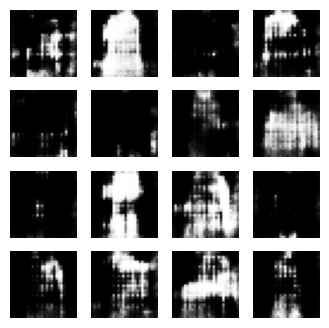

Epoch [1/20] - D Loss: 0.515697, G Loss: 2.171455
Real Accuracy: 0.500000, Fake Accuracy: 1.000000


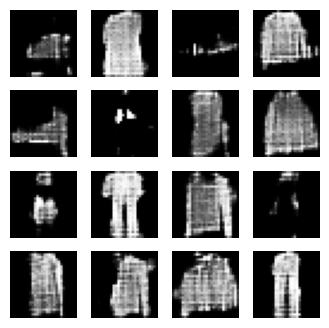

Epoch [2/20] - D Loss: 0.385838, G Loss: 2.461539
Real Accuracy: 0.729167, Fake Accuracy: 1.000000


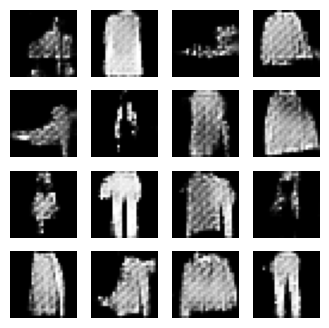

Epoch [3/20] - D Loss: 0.392472, G Loss: 1.449212
Real Accuracy: 0.916667, Fake Accuracy: 0.687500


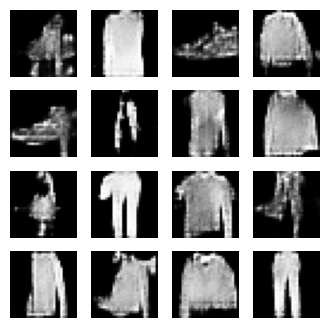

Epoch [4/20] - D Loss: 0.435526, G Loss: 1.560286
Real Accuracy: 0.875000, Fake Accuracy: 0.833333


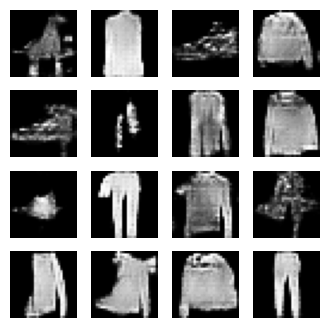

Epoch [5/20] - D Loss: 0.513121, G Loss: 1.118069
Real Accuracy: 0.729167, Fake Accuracy: 0.697917


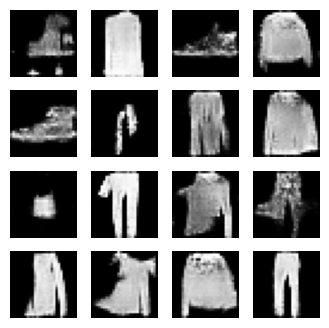

Epoch [6/20] - D Loss: 0.581863, G Loss: 1.307048
Real Accuracy: 0.666667, Fake Accuracy: 0.625000


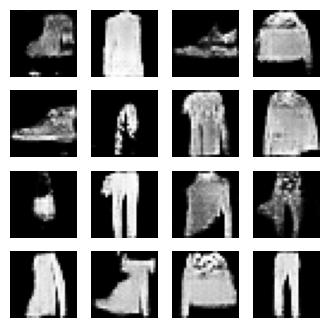

Epoch [7/20] - D Loss: 0.513085, G Loss: 1.016894
Real Accuracy: 0.947917, Fake Accuracy: 0.427083


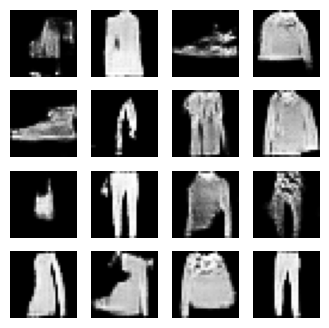

Epoch [8/20] - D Loss: 0.630624, G Loss: 0.962213
Real Accuracy: 0.833333, Fake Accuracy: 0.416667


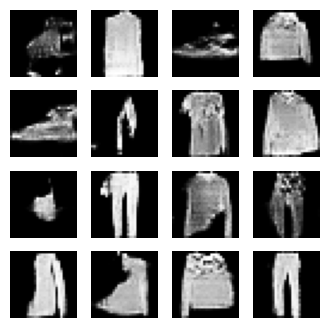

Epoch [9/20] - D Loss: 0.613126, G Loss: 1.197057
Real Accuracy: 0.666667, Fake Accuracy: 0.656250


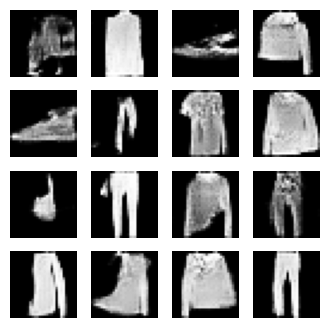

Epoch [10/20] - D Loss: 0.512641, G Loss: 1.113109
Real Accuracy: 0.802083, Fake Accuracy: 0.791667


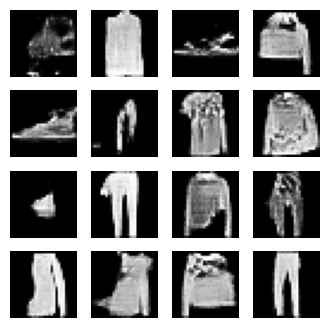

Epoch [11/20] - D Loss: 0.571878, G Loss: 1.271179
Real Accuracy: 0.770833, Fake Accuracy: 0.729167


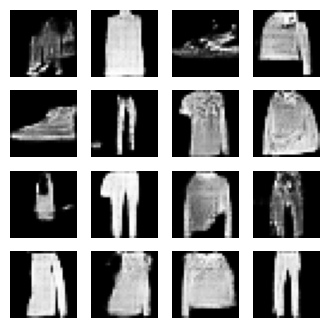

Epoch [12/20] - D Loss: 0.619900, G Loss: 1.555663
Real Accuracy: 0.510417, Fake Accuracy: 0.906250


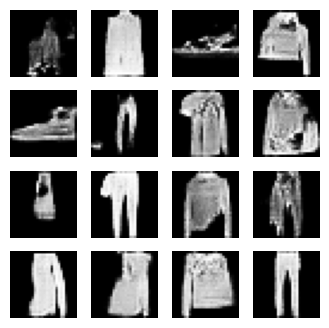

Epoch [13/20] - D Loss: 0.641986, G Loss: 1.268626
Real Accuracy: 0.604167, Fake Accuracy: 0.781250


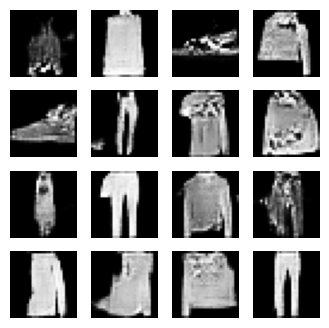

Epoch [14/20] - D Loss: 0.543458, G Loss: 1.356952
Real Accuracy: 0.614583, Fake Accuracy: 0.687500


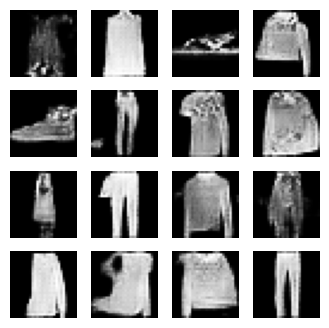

Epoch [15/20] - D Loss: 0.607121, G Loss: 1.138016
Real Accuracy: 0.656250, Fake Accuracy: 0.718750


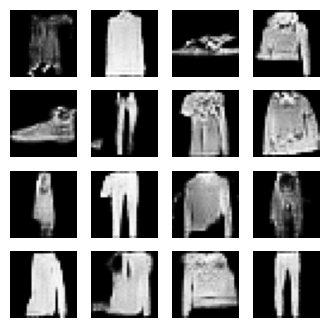

Epoch [16/20] - D Loss: 0.524727, G Loss: 1.074108
Real Accuracy: 0.906250, Fake Accuracy: 0.625000


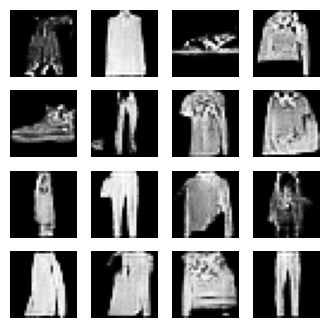

Epoch [17/20] - D Loss: 0.633936, G Loss: 1.105369
Real Accuracy: 0.708333, Fake Accuracy: 0.593750


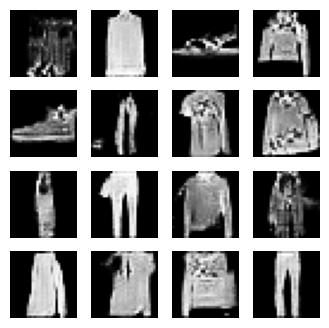

Epoch [18/20] - D Loss: 0.644540, G Loss: 1.000881
Real Accuracy: 0.677083, Fake Accuracy: 0.583333


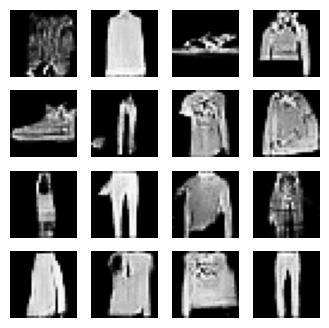

Epoch [19/20] - D Loss: 0.618739, G Loss: 0.950217
Real Accuracy: 0.822917, Fake Accuracy: 0.500000


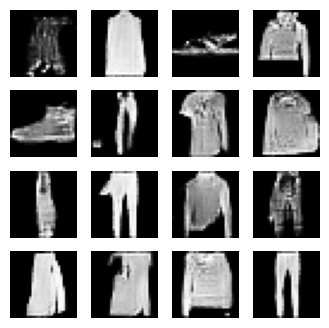

In [26]:
NUM_EPOCHS = 20  # Number of epochs

writer = SummaryWriter('runs/DCGAN_experiment')

# Create an instance of GANMonitor
monitor = GANMonitor(num_img=16, latent_dim=LATENT_DIM)

# Training loop
for epoch in range(NUM_EPOCHS):
    for batch_idx, (real_images, _) in enumerate(data_loader):  # Replace train_loader with your DataLoader
        real_images = real_images.to(device) # Move real_images to the appropriate device

        # Train the DCGAN model for one batch
        training_stats = dcgan(real_images)

        writer.add_scalar('Loss/Discriminator', training_stats['d_loss'], epoch * len(data_loader) + batch_idx)
        writer.add_scalar('Loss/Generator', training_stats['g_loss'], epoch * len(data_loader) + batch_idx)

    # Calculate and print the accuracy metrics for the current epoch
    metrics = dcgan.compute_metrics(real_images)
    print(f"Epoch [{epoch}/{NUM_EPOCHS}] - D Loss: {training_stats['d_loss']:.6f}, G Loss: {training_stats['g_loss']:.6f}")
    print(f"Real Accuracy: {metrics['real_accuracy']:.6f}, Fake Accuracy: {metrics['fake_accuracy']:.6f}")

    writer.add_scalar('Accuracy/Real', metrics['real_accuracy'], epoch)
    writer.add_scalar('Accuracy/Fake', metrics['fake_accuracy'], epoch)


    # Call the GANMonitor callback to visualize generated images at the end of each epoch
    monitor.on_epoch_end(epoch, generator)

# After training, save the generator model
monitor.on_train_end(generator)

